In [10]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob

import gzip
import shutil

from config.config_cloud import Config_cloud

## Functions

In [11]:
def crop_valid(img, meta=True):
    if meta:
        img = img[2:154,8:128]
    else:
        img = img[8:616,32:512]
    return img

def Read_gz_Binary(file):
    file_tmp = file + "_tmp"
    with gzip.open(file, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    bin_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)
    return bin_data.reshape( [168,128] )

In [12]:
root_path = "/mnt/nasbi/no-backups/datasets/video_datasets/cloud_video/"

In [13]:
'''
cloud = np.stack(data['cloud'].values())
np.max(cloud),np.min(cloud)
TMP = np.stack(data['TMP'].values())
np.max(TMP),np.min(TMP)
winds = np.stack(data['winds'].values())
np.max(winds),np.min(winds)
'''
cloud_max_min = [255, 0]
RH_max_min = [100,0]
TMP_max_min = [310, 230]
PRMSL_max_min = [105000, 95000]
winds_max_min = [100,0]
HGTs_max_min = [10000, 8000, 6000, 4800, 3300, 2400, 1700, 700]
blur = 9

# Processing training data

In [14]:
cloud_list = glob.glob(root_path+'train/sat/*/*')
cloud_list = np.sort(cloud_list)

In [ ]:
data = pd.Series()

data['ground'] = {}
data['sky'] = {}

for cloud_path in cloud_list:
    ID = cloud_path.split('/')[-1].split('.')[0]
    year, month, day, hour, _ = ID.split('-')
    appendix = '3.'+year+month+day+hour+'.gz' 
    try:   # unstable feature
        PRMSL_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'PRMSL.msl.'+appendix
        PRMSL = Read_gz_Binary(PRMSL_path)
        PRMSL = crop_valid(PRMSL) 
        PRMSL = cv2.GaussianBlur(PRMSL,(blur,blur),0)
        PRMSL = (PRMSL-PRMSL_max_min[1])/(PRMSL_max_min[0]-PRMSL_max_min[1])
        PRMSL = np.expand_dims(PRMSL,axis=0)
        PRMSL_pad = np.zeros([1,160,128])
        PRMSL_pad[:,2:154,8:128] = PRMSL

        RH_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'RH.1p5m.'+appendix
        RH = Read_gz_Binary(RH_path)
        RH = crop_valid(RH)
        RH = cv2.GaussianBlur(RH,(blur,blur),0)
        RH = (RH-RH_max_min[1])/(RH_max_min[0]-RH_max_min[1])
        RH = np.expand_dims(RH,axis=0)
        RH_pad = np.zeros([1,160,128])
        RH_pad[:,2:154,8:128] = RH   

        ground = np.concatenate([PRMSL_pad,RH_pad],axis=0)
    
        data['ground'][year+month+day+hour] = ground.astype(np.float16)
    except:
        pass
    
    
    try:
        winds = [] 
        HGTs = []
        RHs = []
        for i in [ '.300.','.500.', '.700.', '.850.']:
            UGRD_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'UGRD'+i+appendix
            VGRD_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'VGRD'+i+appendix
            VVEL_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'VVEL'+i+appendix
            HGT_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'HGT'+i+appendix
            RH_path = root_path+'train/met/{}/{}/{}/'.format(year,month,day)+'RH'+i+appendix
        
            UGRD = Read_gz_Binary(UGRD_path)
            UGRD = crop_valid(UGRD) 
            UGRD = cv2.medianBlur(UGRD,5)
            
            VGRD = Read_gz_Binary(VGRD_path)
            VGRD = crop_valid(VGRD)
            VGRD = cv2.medianBlur(VGRD,5)
            
            VVEL = Read_gz_Binary(VVEL_path)
            VVEL = crop_valid(VVEL)
            VVEL = cv2.medianBlur(VVEL,5)
            
            HGT = Read_gz_Binary(HGT_path)
            HGT = crop_valid(HGT) 
            HGT = cv2.medianBlur(HGT,5)
            
            RH = Read_gz_Binary(RH_path)
            RH = crop_valid(RH)
            RH = cv2.medianBlur(RH,5)
                       
            winds.append(UGRD)
            winds.append(VGRD)
            winds.append(VVEL)
            HGTs.append(HGT)
            RHs.append(RH)
    
        winds = np.stack(winds, axis=0)
        winds = (winds-winds_max_min[1])/(winds_max_min[0]-winds_max_min[1])   
        winds_pad = np.zeros([12,160,128]) 
        winds_pad[:,2:154,8:128] = winds 
 
        HGTs = np.stack(HGTs)
        HGTs[0] = (HGTs[0]-HGTs_max_min[1])/(HGTs_max_min[0]-HGTs_max_min[1])
        HGTs[1] = (HGTs[1]-HGTs_max_min[3])/(HGTs_max_min[2]-HGTs_max_min[3])
        HGTs[2] = (HGTs[2]-HGTs_max_min[5])/(HGTs_max_min[4]-HGTs_max_min[5])
        HGTs[3] = (HGTs[3]-HGTs_max_min[7])/(HGTs_max_min[6]-HGTs_max_min[7])
        HGTs_pad = np.zeros([4,160,128])
        HGTs_pad[:,2:154,8:128] = HGTs
              
        RHs = np.stack(RHs)
        RHs = (RHs-RH_max_min[1])/(RH_max_min[0]-RH_max_min[1])        
        RHs_pad = np.zeros([4,160,128]) 
        RHs_pad[:,2:154,8:128] = RHs 

        sky = np.concatenate([HGTs_pad,RHs_pad,winds_pad],axis=0)
        data['sky'][year+month+day+hour] = sky.astype(np.float16)

    except:
        pass
    
data.to_pickle("data/data_train_met.pkl")


In [7]:
HGTs.shape, RHs.shape, winds.shape, RH.shape

((4, 152, 120), (4, 152, 120), (12, 152, 120), (152, 120))

In [19]:
np.max(data['ground']['2016010103']), data['ground']['2016010103'].shape

(0.959, (4, 160, 128))

In [20]:
np.max(data['sky']['2016010103'][:9,:,:]),data['sky']['2016010103'].shape

(0.9995, (20, 160, 128))

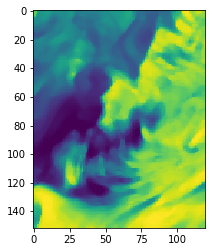

In [9]:

plt.imshow(RH.astype(np.float32))
plt.show()

In [47]:
'''
for i in RH:
    plt.imshow(np.squeeze(i).astype(np.float32))
    plt.show()

for i in winds:
    plt.imshow(i.transpose(1,2,0)[:,:,:3].astype(np.float32))
    plt.show()
for HG in HGTs:
    plt.imshow(HG.transpose(1,2,0).astype(np.float32))
    plt.show()
'''

'\nfor i in RH:\n    plt.imshow(np.squeeze(i).astype(np.float32))\n    plt.show()\n\nfor i in winds:\n    plt.imshow(i.transpose(1,2,0)[:,:,:3].astype(np.float32))\n    plt.show()\nfor HG in HGTs:\n    plt.imshow(HG.transpose(1,2,0).astype(np.float32))\n    plt.show()\n'

# Processing testing data

In [ ]:
cloud_list = glob.glob(root_path+'test/sat/*/*')
cloud_list = np.sort(cloud_list)

In [ ]:
data = pd.Series()

data['ground'] = {}
data['sky'] = {}

for cloud_path in cloud_list:
    ID = cloud_path.split('/')[-1].split('.')[0]
    year, month, day, hour, _ = ID.split('-')
    appendix = '3.'+year+month+day+hour+'.gz' 
    try:   # unstable feature
        PRMSL_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'PRMSL.msl.'+appendix
        PRMSL = Read_gz_Binary(PRMSL_path)
        PRMSL = crop_valid(PRMSL) 
        PRMSL = cv2.GaussianBlur(PRMSL,(blur,blur),0)
        PRMSL = (PRMSL-PRMSL_max_min[1])/(PRMSL_max_min[0]-PRMSL_max_min[1])
        PRMSL = np.expand_dims(PRMSL,axis=0)
        PRMSL_pad = np.zeros([1,160,128])
        PRMSL_pad[:,2:154,8:128] = PRMSL

        RH_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'RH.1p5m.'+appendix
        RH = Read_gz_Binary(RH_path)
        RH = crop_valid(RH)
        RH = cv2.GaussianBlur(RH,(blur,blur),0)
        RH = (RH-RH_max_min[1])/(RH_max_min[0]-RH_max_min[1])
        RH = np.expand_dims(RH,axis=0)
        RH_pad = np.zeros([1,160,128])
        RH_pad[:,2:154,8:128] = RH   

        ground = np.concatenate([PRMSL_pad,RH_pad],axis=0)
    
        data['ground'][year+month+day+hour] = ground.astype(np.float16)
    except:
        pass
    
    
    try:
        winds = [] 
        HGTs = []
        RHs = []
        for i in [ '.300.','.500.', '.700.', '.850.']:
            UGRD_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'UGRD'+i+appendix
            VGRD_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'VGRD'+i+appendix
            VVEL_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'VVEL'+i+appendix
            HGT_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'HGT'+i+appendix
            RH_path = root_path+'test/met/{}/{}/{}/'.format(year,month,day)+'RH'+i+appendix
        
            UGRD = Read_gz_Binary(UGRD_path)
            UGRD = crop_valid(UGRD) 
            UGRD = cv2.medianBlur(UGRD,5)
            
            VGRD = Read_gz_Binary(VGRD_path)
            VGRD = crop_valid(VGRD)
            VGRD = cv2.medianBlur(VGRD,5)
            
            VVEL = Read_gz_Binary(VVEL_path)
            VVEL = crop_valid(VVEL)
            VVEL = cv2.medianBlur(VVEL,5)
            
            HGT = Read_gz_Binary(HGT_path)
            HGT = crop_valid(HGT) 
            HGT = cv2.medianBlur(HGT,5)
            
            RH = Read_gz_Binary(RH_path)
            RH = crop_valid(RH)
            RH = cv2.medianBlur(RH,5)
                       
            winds.append(UGRD)
            winds.append(VGRD)
            winds.append(VVEL)
            HGTs.append(HGT)
            RHs.append(RH)
    
        winds = np.stack(winds, axis=0)
        winds = (winds-winds_max_min[1])/(winds_max_min[0]-winds_max_min[1])   
        winds_pad = np.zeros([12,160,128]) 
        winds_pad[:,2:154,8:128] = winds 
 
        HGTs = np.stack(HGTs)
        HGTs[0] = (HGTs[0]-HGTs_max_min[1])/(HGTs_max_min[0]-HGTs_max_min[1])
        HGTs[1] = (HGTs[1]-HGTs_max_min[3])/(HGTs_max_min[2]-HGTs_max_min[3])
        HGTs[2] = (HGTs[2]-HGTs_max_min[5])/(HGTs_max_min[4]-HGTs_max_min[5])
        HGTs[3] = (HGTs[3]-HGTs_max_min[7])/(HGTs_max_min[6]-HGTs_max_min[7])
        HGTs_pad = np.zeros([4,160,128])
        HGTs_pad[:,2:154,8:128] = HGTs
              
        RHs = np.stack(RHs)
        RHs = (RHs-RH_max_min[1])/(RH_max_min[0]-RH_max_min[1])        
        RHs_pad = np.zeros([4,160,128]) 
        RHs_pad[:,2:154,8:128] = RHs 

        sky = np.concatenate([HGTs_pad,RHs_pad,winds_pad],axis=0)
        data['sky'][year+month+day+hour] = sky.astype(np.float16)

    except:
        pass
    
data.to_pickle("data/data_test_met.pkl")


### Testing list

In [37]:
Cfg = Config_cloud()

In [38]:
from datetime import datetime
data = pd.read_pickle('data/data_test_met.pkl')
df = pd.read_csv('data/inference_terms.csv')

meta_time = list(data['HGTs'].keys())
meta_time = np.sort(meta_time).astype(int)
df.head()

,OpenData_96hr_Start,OpenData_96hr_End,Inference_24hr_Start,Inference_24hr_End,Evaluation_06hr,Evaluation_12hr,Evaluation_18hr,Evaluation_24hr
0,2018/1/2 16:00,2018/1/6 15:00,2018/1/6 16:00,2018/1/7 15:00,2018/1/6 21:00,2018/1/7 3:00,2018/1/7 9:00,2018/1/7 15:00
1,2018/1/9 16:00,2018/1/13 15:00,2018/1/13 16:00,2018/1/14 15:00,2018/1/13 21:00,2018/1/14 3:00,2018/1/14 9:00,2018/1/14 15:00
2,2018/1/16 16:00,2018/1/20 15:00,2018/1/20 16:00,2018/1/21 15:00,2018/1/20 21:00,2018/1/21 3:00,2018/1/21 9:00,2018/1/21 15:00
3,2018/1/23 16:00,2018/1/27 15:00,2018/1/27 16:00,2018/1/28 15:00,2018/1/27 21:00,2018/1/28 3:00,2018/1/28 9:00,2018/1/28 15:00
4,2018/1/30 16:00,2018/2/3 15:00,2018/2/3 16:00,2018/2/4 15:00,2018/2/3 21:00,2018/2/4 3:00,2018/2/4 9:00,2018/2/4 15:00


In [43]:
cloud_clip = []
meta_clip = []
for i in range(len(df)):
    date_s = df.OpenData_96hr_Start[i]
    date_s = datetime.strptime(date_s, '%Y/%m/%d %H:%M')
    date_s = date_s.strftime('%Y%m%d%H')
    
    date_e = df.OpenData_96hr_End[i]
    date_e = datetime.strptime(date_e, '%Y/%m/%d %H:%M')
    date_e = date_e.strftime('%Y%m%d%H')
    
    s_ind = np.where(meta_time>=int(date_s))[0][0]
    e_ind = np.where(meta_time<=int(date_e))[0][-1]

    meta_clip.append(meta_time[s_ind:e_ind+1])


In [45]:
np.save("data/test_meta_clip.npy", meta_clip)

In [44]:
meta_clip

[array([2018010218, 2018010221, 2018010300, 2018010303, 2018010306,
        2018010309, 2018010312, 2018010315, 2018010318, 2018010321,
        2018010400, 2018010403, 2018010406, 2018010409, 2018010412,
        2018010415, 2018010418, 2018010421, 2018010500, 2018010503,
        2018010506, 2018010509, 2018010512, 2018010515, 2018010518,
        2018010521, 2018010600, 2018010603, 2018010606, 2018010609,
        2018010612, 2018010615]),
 array([2018010918, 2018010921, 2018011000, 2018011003, 2018011006,
        2018011009, 2018011012, 2018011015, 2018011018, 2018011021,
        2018011100, 2018011103, 2018011106, 2018011109, 2018011112,
        2018011115, 2018011118, 2018011121, 2018011200, 2018011203,
        2018011206, 2018011209, 2018011212, 2018011215, 2018011218,
        2018011221, 2018011300, 2018011303, 2018011306, 2018011309,
        2018011312, 2018011315]),
 array([2018011618, 2018011621, 2018011700, 2018011703, 2018011706,
        2018011709, 2018011712, 2018011715, 2018